Import Dependencies

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt

Load  data into a  DataFrame

In [2]:
mb_raw_data = pd.read_csv('/Users/simon/PycharmProjects/ion-mobility-prediction/data/mann_bruker.txt', sep='\t')
mb_data_frame = pd.DataFrame(mb_raw_data)
# Delete all columns except Sequence, m/z, and CCS
mb_clean_frame = mb_data_frame[['Sequence', 'm/z', 'CCS']]
# Log transform CCS values
mb_clean_frame['CCS_ln'] = mb_clean_frame['CCS'].apply(lambda x: np.log(x))

/var/folders/h8/62vn1gzj3456t6qsdpq7mx3w0000gn/T/ipykernel_52018/2693796677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_ln'] = mb_clean_frame['CCS'].apply(lambda x: np.log(x))


Train Model

In [3]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[['m/z']]
y = mb_clean_frame['CCS_ln']
# Define the number of folds
k = 4

Perform k-fold cross validation

In [4]:
# Initialize the cross-validation object
kf = KFold(n_splits=k)

# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a random forest regressor model
    model = RandomForestRegressor(n_estimators=50, random_state=1,n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    relative_errors = np.abs((y_pred - y_test) / y_test)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)

# Find the index of the fold with the lowest MSE
best_fold_index = mse_scores.index(min(mse_scores))
# Split the data into training and testing sets for the best fold
X_train_best, X_test_best = X.iloc[kf.split(X).__next__()[0]], X.iloc[kf.split(X).__next__()[1]]
y_train_best, y_test_best = y.iloc[kf.split(y).__next__()[0]], y.iloc[kf.split(y).__next__()[1]]

# Create the final model using the best fold
final_model = RandomForestRegressor(n_estimators=20, random_state=1,n_jobs=-1)
final_model.fit(X, y)
# Print all mse scores
print("All Mean Squared Errors:", mse_scores)
# Average the MSE scores
average_mse = np.mean(mse_scores)
# Print the average MSE score
print("Average Mean Squared Error:", average_mse)
# Print the median of the relative errors for each fold
print("Median Relative Errors:", median_relative_errors)

All Mean Squared Errors: [0.11152090607608169, 0.11721767819118965, 0.10107830303641117, 0.10508282418843864]
Average Mean Squared Error: 0.10872492787303029
Median Relative Errors: [0.00041252991419642247, 0.00041302017555682065, 0.0004018304590803159, 0.00040198966371371696]


In [5]:
# Input the m/z value of the peptide you want to predict the CCS of
mz = 1074.04135
# Predict the CCS of the peptide
ccs = final_model.predict([[mz]])
# Reverse the log transformation
ccs = np.exp(ccs)
print("Predicted CCS:", ccs)

Predicted CCS: [1.37247049e-35]


/Users/simon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Save the model

In [6]:
# Save the model to a file
filename = 'random_forest_model.pkl'
pickle.dump(model, open(filename, 'wb'))

Comparing accuracy of the model based on sequence length

In [7]:
# Add a column to the data frame with the length of each peptide sequence
mb_clean_frame['Sequence Length'] = mb_clean_frame['Sequence'].apply(lambda x: len(x))
# Predict the CCS of the peptides in the data frame
mb_clean_frame['Predicted CCS'] = final_model.predict(mb_clean_frame[['m/z']])
# Reverse the log transformation
mb_clean_frame['Predicted CCS'] = np.exp(mb_clean_frame['Predicted CCS'])

/var/folders/h8/62vn1gzj3456t6qsdpq7mx3w0000gn/T/ipykernel_52018/1414671599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['Sequence Length'] = mb_clean_frame['Sequence'].apply(lambda x: len(x))
/var/folders/h8/62vn1gzj3456t6qsdpq7mx3w0000gn/T/ipykernel_52018/1414671599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['Predicted CCS'] = final_model.predict(mb_clean_frame[['m/z']])
/var/folders/h8/62vn1gzj3456t6qsdpq7mx3w0000gn/T/ipykernel_52018/1414671599.py:6: SettingW

Spearman's Correlation Coefficient: 0.9800947452873889


/var/folders/h8/62vn1gzj3456t6qsdpq7mx3w0000gn/T/ipykernel_52018/50598253.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])


<AxesSubplot:xlabel='Sequence Length', ylabel='Percent Error'>

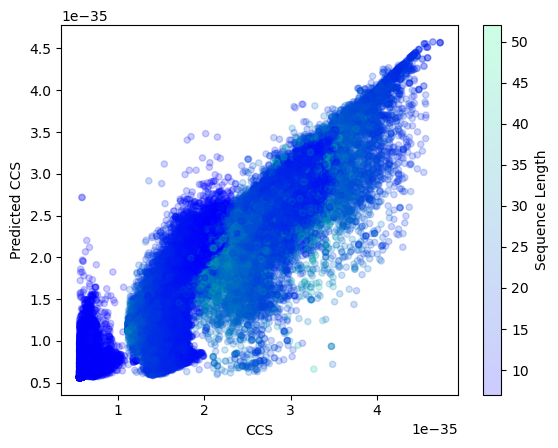

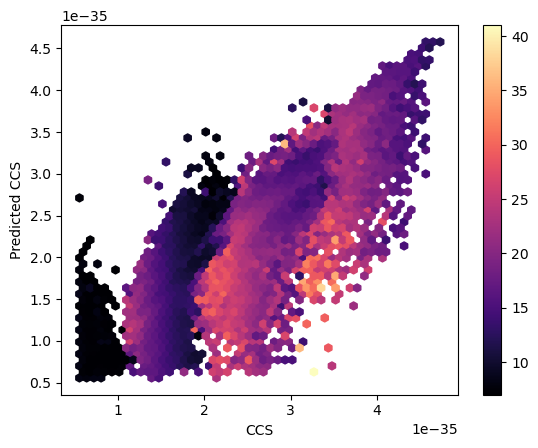

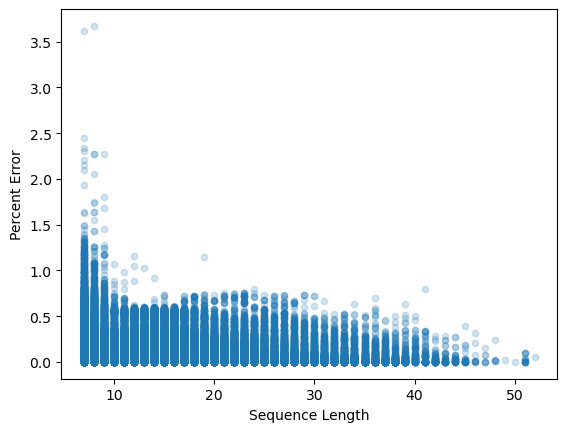

In [8]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Sequence Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Sequence Length'].min(),
    vmax=mb_clean_frame['Sequence Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Sequence Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
#Now we want to create a plot with percent error between CCS and Predictes CCS and graph that by sequence length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Sequence Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Sequence Length'].min(),
    vmax=mb_clean_frame['Sequence Length'].max()
)